In [0]:
import numpy as np
import pandas as pd
import re, torch, time
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.utils.data

In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/INF8111/data/preprocess_balanced.pkl")

Text(0.5, 1.0, 'Sequence length distribution')

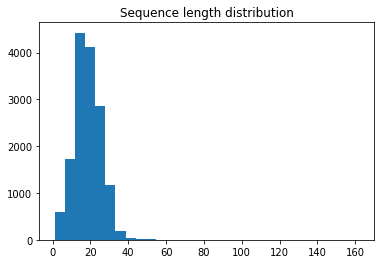

In [18]:
plt.hist([len(x) for x in data.tweet], bins=30)
plt.title("Sequence length distribution")

In [0]:
vocab_max = 50000
seq_length = 30
count_words = Counter()
for tweet in data.tweet:
    for tok in tweet:
        count_words[tok] +=1
vocab = {w for w,_ in count_words.most_common(vocab_max-2)}.union( {"UNK", "PAD"})
word2val = {w : i+2 for i, (w,_) in enumerate( count_words.most_common(vocab_max-2) )}
word2val["PAD"] = 0
word2val["UNK"] = 1
X = []
for tweet in data.tweet:
    tmp = [word2val[tok] if tok in vocab else word2val["UNK"] for tok in tweet]
    if len(tmp) > seq_length:
        X.append(tmp[:seq_length])
    else:
        X.append([0 for _ in range(seq_length - len(tmp))] + tmp)
X = np.array(X)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, np.array(data.label), test_size=0.33, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_valid = torch.tensor(y_valid)
y_test = torch.tensor(y_test)
train_data = torch.utils.data.TensorDataset(X_train, y_train)
valid_data = torch.utils.data.TensorDataset(X_valid, y_valid)
test_data = torch.utils.data.TensorDataset(X_test, y_test)

In [0]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [0]:
class RNN(nn.Module):
    def __init__(self,
                 emb_size,
                 hidden_size,
                 vocab_size,
                 num_layers,
                 output_size,
                 nonlinearity = 'relu',
                 bias = True,
                 dropout = 0,
                 bidirectional = True
                ):
        super(RNN, self).__init__()
        #hyper-parameters
        self.emb_size      = emb_size
        self.hidden_size   = hidden_size
        self.vocab_size    = vocab_size
        self.num_layers    = num_layers
        self.output_size   = output_size
        self.nonlinearity  = nonlinearity
        self.bias          = bias
        self.dropout       = dropout
        self.bidirectional = bidirectional
        #layers
        self.embedding = nn.Embedding(vocab_size, emb_size).to(device)
        self.rnn = nn.GRU(input_size = emb_size,
                          hidden_size = hidden_size,
                          num_layers = num_layers,
                          bias = bias,
                          dropout = dropout,
                          bidirectional = bidirectional
                         ).to(device)
        self.linear = nn.Linear((bidirectional+1) *hidden_size, output_size).to(device)
        
    def forward(self, X):
        out = self.embedding(X.t())
        out, _ = self.rnn(out)
        return self.linear(out[-1])

In [0]:
rnn = RNN( emb_size = 1024,
         hidden_size = 512,
         vocab_size = vocab_max,
         num_layers = 3,
         output_size = 4,
         bidirectional=True)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(),weight_decay=10e-5)

In [30]:
n_epochs = 5
start_time = time.time()
last_time = time.time()
for epoch in range(1, n_epochs+1):
    print("Epoch: {}/{}".format(epoch, n_epochs))
    running_loss = 0
    correct = 0
    for i, (X_batch, y_batch) in enumerate(train_loader):
        torch.cuda.empty_cache()
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        out = rnn.forward(X_batch.to(device))
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (torch.max(out, 1)[1] == y_batch).float().sum()
        if time.time() - last_time > 0.5:
            print("Samples:{}/{}\tloss: {:.4f}\tacc: {:2.3f}\telapsed_time: {:.1f}s"\
                  .format( (i+1)*batch_size, len(train_loader.dataset),\
                          running_loss/((i+1)*batch_size), 100*correct/((i+1)*batch_size), time.time()-start_time), end='\r')
            last_time = time.time()
    print("Samples:{}/{}\tloss: {:.4f}\tacc: {:2.3f}\telapsed_time: {:.1f}s\tvalid_acc: {:2.3f}"\
          .format( (i+1)*batch_size, len(train_loader.dataset),\
                  running_loss/((i+1)*batch_size), 100*correct/((i+1)*batch_size), time.time()-start_time,
                  100*(rnn(X_valid.to(device)).max(dim=1)[1] == y_valid.to(device)).float().sum()/len(y_valid.to(device))), flush=True)
    print("test_acc : {:2.3f}".format(100*(rnn(X_test.to(device)).max(dim=1)[1] == y_test.to(device)).float().sum()/len(y_test)))

Epoch: 1/5
Samples:10176/10151	loss: 0.0103	acc: 72.474	elapsed_time: 33.3s	valid_acc: 68.720


RuntimeError: ignored

In [44]:
correct = 0
for i, (X_batch, y_batch) in enumerate(test_loader):
  torch.cuda.empty_cache()
  X_batch = X_batch.to(device)
  y_batch = y_batch.to(device)
  out = rnn.forward(X_batch.to(device))
  correct += (torch.max(out, 1)[1] == y_batch).float().sum()
print(100*correct/len(test_loader.dataset))

tensor(68.2927, device='cuda:0')


In [42]:
len(test_loader.dataset)

2501